In [437]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import importlib
from paddleocr import PaddleOCR
import json
import os

print("Numpy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

Numpy version: 1.26.3
OpenCV version: 4.6.0


In [438]:
import sys
sys.path.append("..")

# Add Python modules here which you are working with, so that you can reload them
# without need of restarting the kernel.
import src.evaluation as evaluation
import src.count_features as count_features
import src.extract_color as extract_color
_=importlib.reload(extract_color)
_ = importlib.reload(evaluation)
_ = importlib.reload(count_features)


In [439]:
from src.count_features import draw_bounding_boxes, compute_feature_counts, filter_by_feature_count
from src.evaluation import evaluate_filter_functions
from src.extract_color import extract_color,euclidean_Dist,filter_by_color
from src.load_data import load_and_process_eTRIMS

In [440]:
image_folder = "../data/testing/low_res_wall_texture"

data = {}
for filename in os.listdir(image_folder):
    name = filename[:-4]  # remove .jpg
    image = cv2.imread(image_folder + "/" + filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    data[name] = gray_image[..., ::-1]

<Figure size 640x480 with 0 Axes>

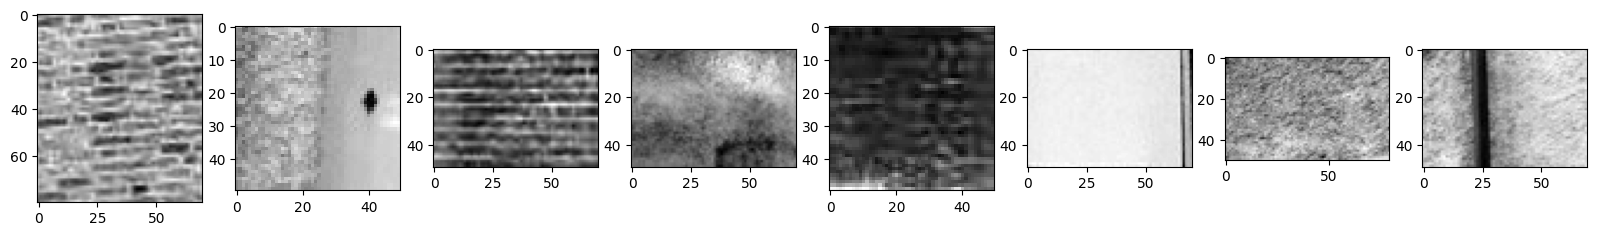

In [441]:
plt.figure()
# rows, columns
f, axarr = plt.subplots(1, 8, figsize=(20,10))

for i in range(8):
    axarr[i].imshow(list(data.values())[i])
plt.show()

In [442]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb

In [443]:
# settings for LBP
radius = 2
n_points = 8 * radius

image = list(data.values())[0]
lbp = local_binary_pattern(image, n_points, radius, method='uniform')

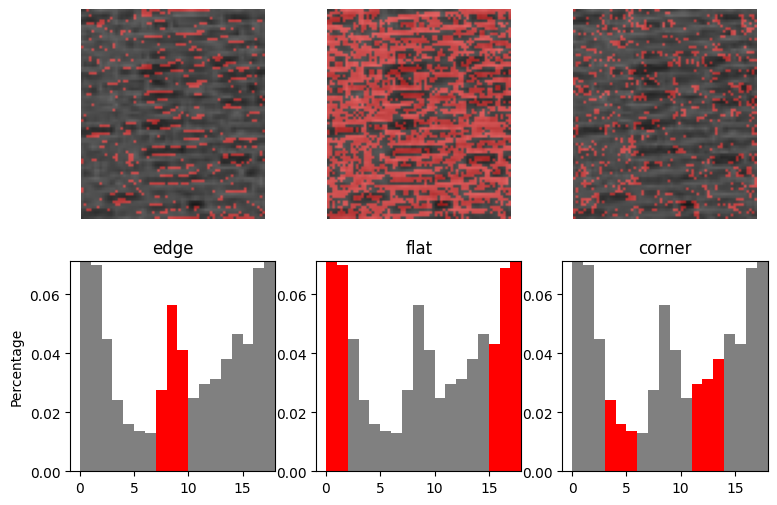

In [444]:
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

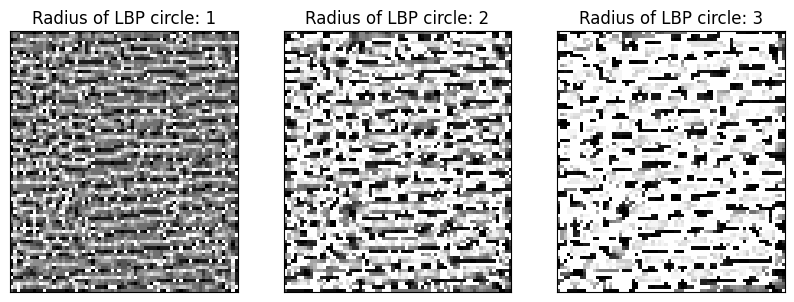

In [445]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10,10))
for i in range(3):
    radius = i+1
    n_points = 8 * radius

    lbp = local_binary_pattern(image, n_points, radius, method='uniform')

    axes[i].imshow(lbp, cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(f'Radius of LBP circle: {radius}')

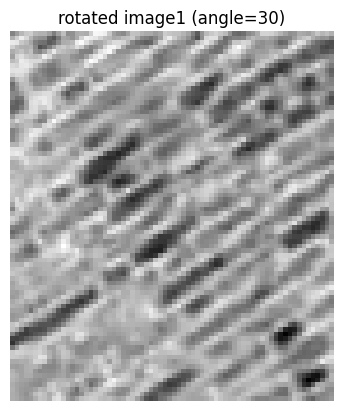

Rotated images matched against references using LBP:
original: image1, rotated: 30deg, match result:  image1
original: image1, rotated: 70deg, match result:  image1
original: image2, rotated: 145deg, match result:  image2

Rotated image match scores against references using LBP (lower is better):
original: image1, rotated: 30deg, match result:
image1 score: 0.026799480507698988
image2 score: 0.05439182787610227
image3 score: 0.030012016795718802
image4 score: 0.05807161798385027
image5 score: 0.04809841870908721
image6 score: 0.13731111738730023
image7 score: 0.2707840738085326
image8 score: 0.0771403205176823


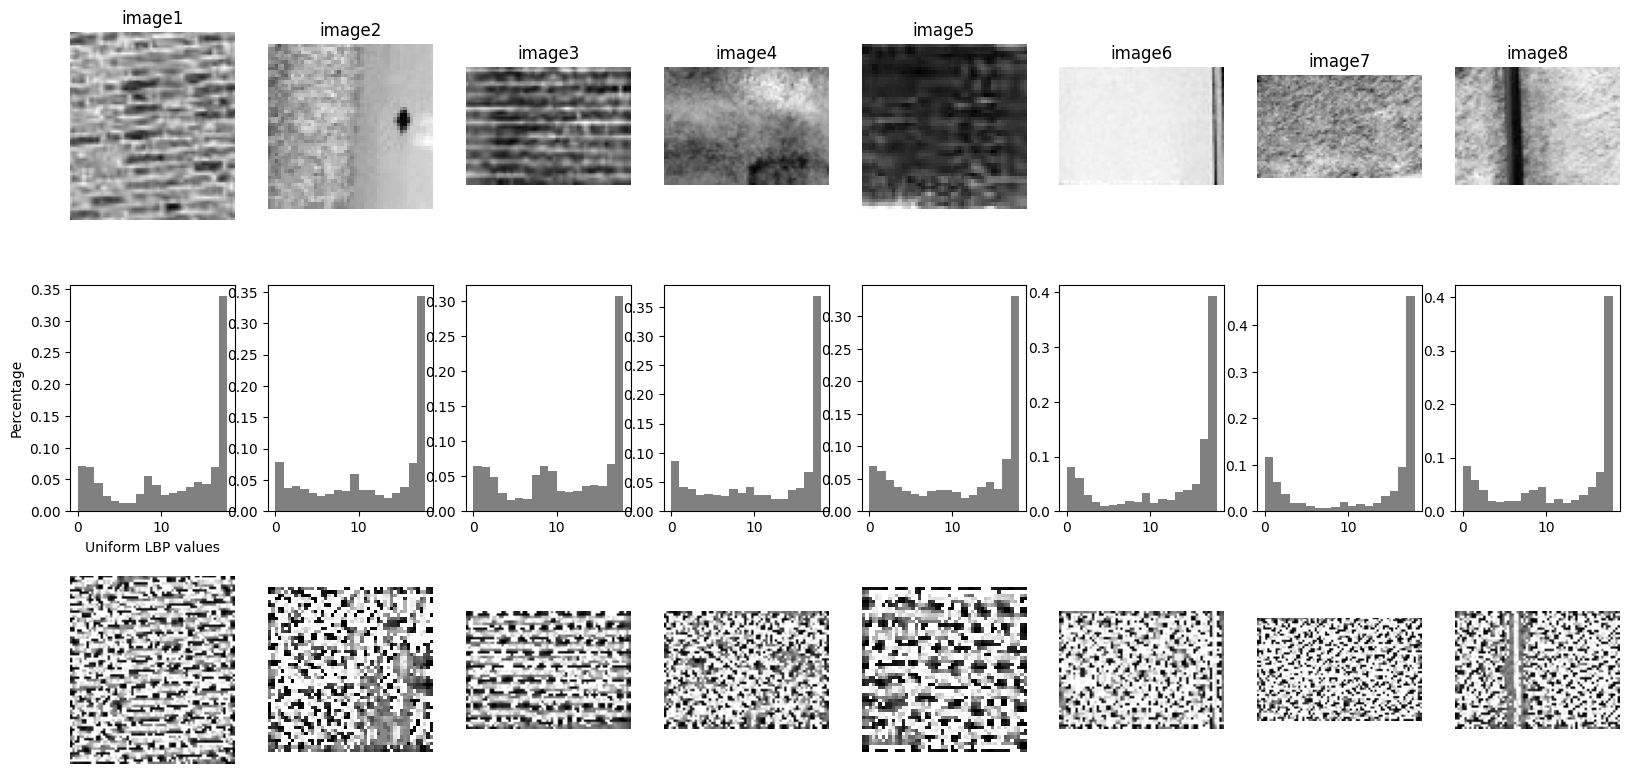

In [446]:
# settings for LBP
radius = 2
n_points = 8 * radius
METHOD = 'uniform'


def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


def scores(refs, img):
    best_score = 10
    best_name = None
    score_dict = {}
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        score_dict[name] = score
    return score_dict


image1 = list(data.values())[0]
image2 = list(data.values())[1]
image3 = list(data.values())[2]
image4 = list(data.values())[3]
image5 = list(data.values())[4]
image6 = list(data.values())[5]
image7 = list(data.values())[6]
image8 = list(data.values())[7]

refs = {
    'image1': local_binary_pattern(image1, n_points, radius, METHOD),
    'image2': local_binary_pattern(image2, n_points, radius, METHOD),
    'image3': local_binary_pattern(image3, n_points, radius, METHOD),
    'image4': local_binary_pattern(image4, n_points, radius, METHOD),
    'image5': local_binary_pattern(image5, n_points, radius, METHOD),
    'image6': local_binary_pattern(image6, n_points, radius, METHOD),
    'image7': local_binary_pattern(image7, n_points, radius, METHOD),
    'image8': local_binary_pattern(image8, n_points, radius, METHOD),
}

# Visualize rotated image
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.gray()
ax.imshow(rotate(image1, angle=30, resize=False, mode='symmetric'))
ax.axis('off')
ax.set_title('rotated image1 (angle=30)')
plt.show()

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: image1, rotated: 30deg, match result: ',
      match(refs, rotate(image1, angle=30, resize=False, mode='symmetric')))
print('original: image1, rotated: 70deg, match result: ',
      match(refs, rotate(image1, angle=70, resize=False, mode='symmetric')))
print('original: image2, rotated: 145deg, match result: ',
      match(refs, rotate(image2, angle=145, resize=False, mode='symmetric')))
print()

print('Rotated image match scores against references using LBP (lower is better):')
print('original: image1, rotated: 30deg, match result:')
img1_scores = scores(refs, rotate(image1, angle=30, resize=False, mode='symmetric'))
for image_name, image_score in img1_scores.items():
    print(f'{image_name} score: {image_score}')

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20, ax21, ax22, ax23, ax24)) = plt.subplots(nrows=3, ncols=8, figsize=(20,10))
plt.gray()

ax1.imshow(image1)
ax1.axis('off')
ax1.set_title('image1')
ax17.imshow(refs['image1'])
ax17.axis('off')
hist(ax9, refs['image1'])
ax9.set_ylabel('Percentage')
ax9.set_xlabel('Uniform LBP values')

ax2.imshow(image2)
ax2.axis('off')
ax2.set_title('image2')
ax18.imshow(refs['image2'])
ax18.axis('off')
hist(ax10, refs['image2'])

ax3.imshow(image3)
ax3.axis('off')
ax3.set_title('image3')
ax19.imshow(refs['image3'])
ax19.axis('off')
hist(ax11, refs['image3'])

ax4.imshow(image4)
ax4.axis('off')
ax4.set_title('image4')
ax20.imshow(refs['image4'])
ax20.axis('off')
hist(ax12, refs['image4'])

ax5.imshow(image5)
ax5.axis('off')
ax5.set_title('image5')
ax21.imshow(refs['image5'])
ax21.axis('off')
hist(ax13, refs['image5'])

ax6.imshow(image6)
ax6.axis('off')
ax6.set_title('image6')
ax22.imshow(refs['image6'])
ax22.axis('off')
hist(ax14, refs['image6'])

ax7.imshow(image7)
ax7.axis('off')
ax7.set_title('image7')
ax23.imshow(refs['image7'])
ax23.axis('off')
hist(ax15, refs['image7'])

ax8.imshow(image8)
ax8.axis('off')
ax8.set_title('image8')
ax24.imshow(refs['image8'])
ax24.axis('off')
hist(ax16, refs['image8'])

plt.show()

# Testing with full size masked images

<Figure size 640x480 with 0 Axes>

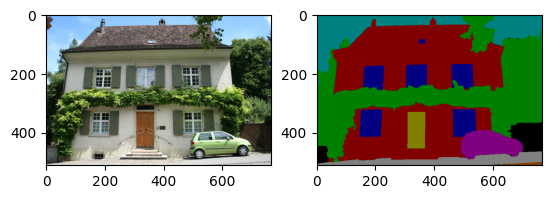

In [447]:
eTRIMS_annotations_folder = "../data/etrims-db_v1/annotations_08etrims-ds"
eTRIMS_images_folder = "../data/etrims-db_v1/images_08_etrims-ds"

data = load_and_process_eTRIMS(eTRIMS_annotations_folder, eTRIMS_images_folder)

plt.figure()
# rows, columns
f, axarr = plt.subplots(1,2)

axarr[0].imshow(list(data.values())[0].image)
axarr[1].imshow(list(data.values())[0].annotation)
plt.show()

<Figure size 640x480 with 0 Axes>

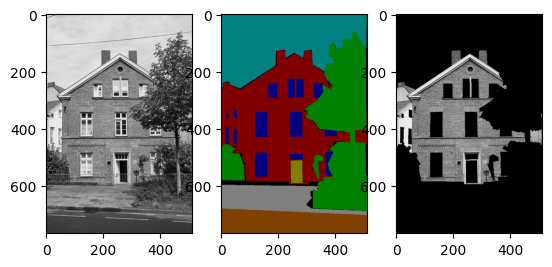

In [448]:
image_name = 'bonn_000047'
image = data[image_name].image
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_annotation = data[image_name].annotation

mask = data[image_name].masks['building'].astype(np.uint8)
masked = cv2.bitwise_and(image, image, mask=mask)

plt.figure()
# rows, columns
f, axarr = plt.subplots(1,3)

axarr[0].imshow(image)
axarr[1].imshow(image_annotation)
axarr[2].imshow(masked)
plt.show()


In [449]:
radius = 2
n_points = 8 * radius

image = masked
lbp = local_binary_pattern(image, n_points, radius, method='uniform')

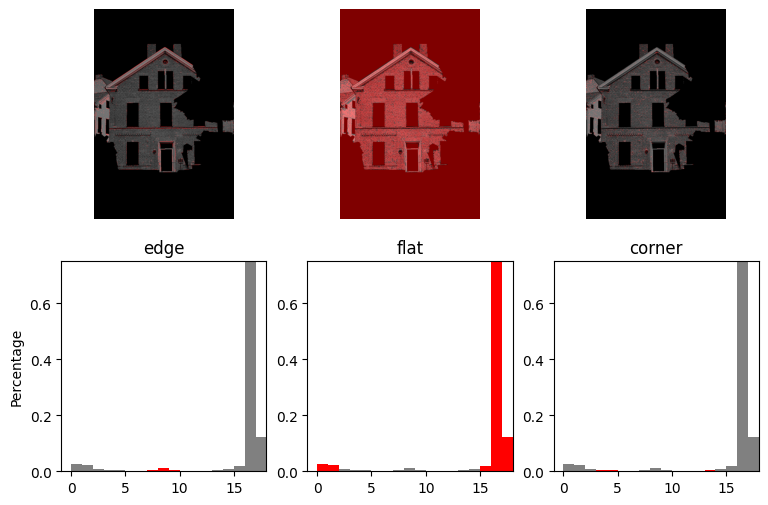

In [450]:
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

# Testing with full images

In [451]:
image_name = 'bonn_000047'
image = data[image_name].image
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

lbp = local_binary_pattern(image, n_points, radius, method='uniform')

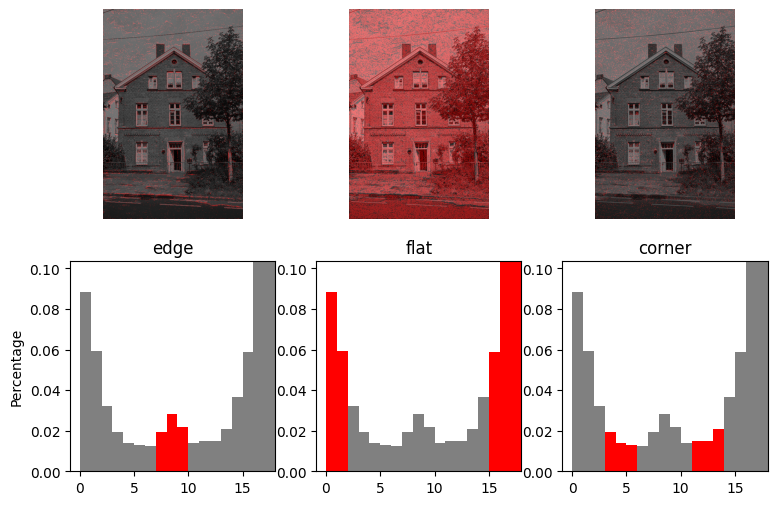

In [452]:
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

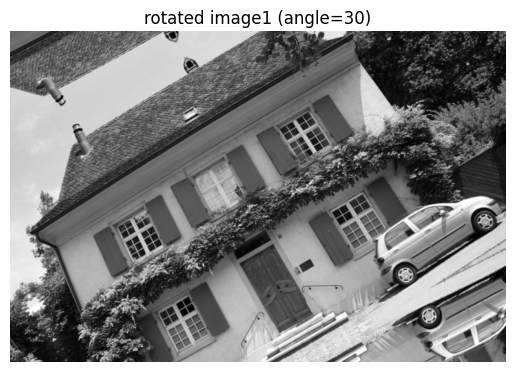

Rotated images matched against references using LBP:
original: image1, rotated: 30deg, match result:  image8
original: image1, rotated: 70deg, match result:  image8
original: image2, rotated: 145deg, match result:  image8

Rotated image match scores against references using LBP (lower is better):
original: image1, rotated: 10deg, match result:
image1 score: 0.04067558383718804
image2 score: 0.07645666958115555
image3 score: 0.07704203094391625
image4 score: 0.02984201721089265
image5 score: 0.0931477199089908
image6 score: 0.05945035113140837
image7 score: 0.04075429238166213
image8 score: 0.01657499090439434


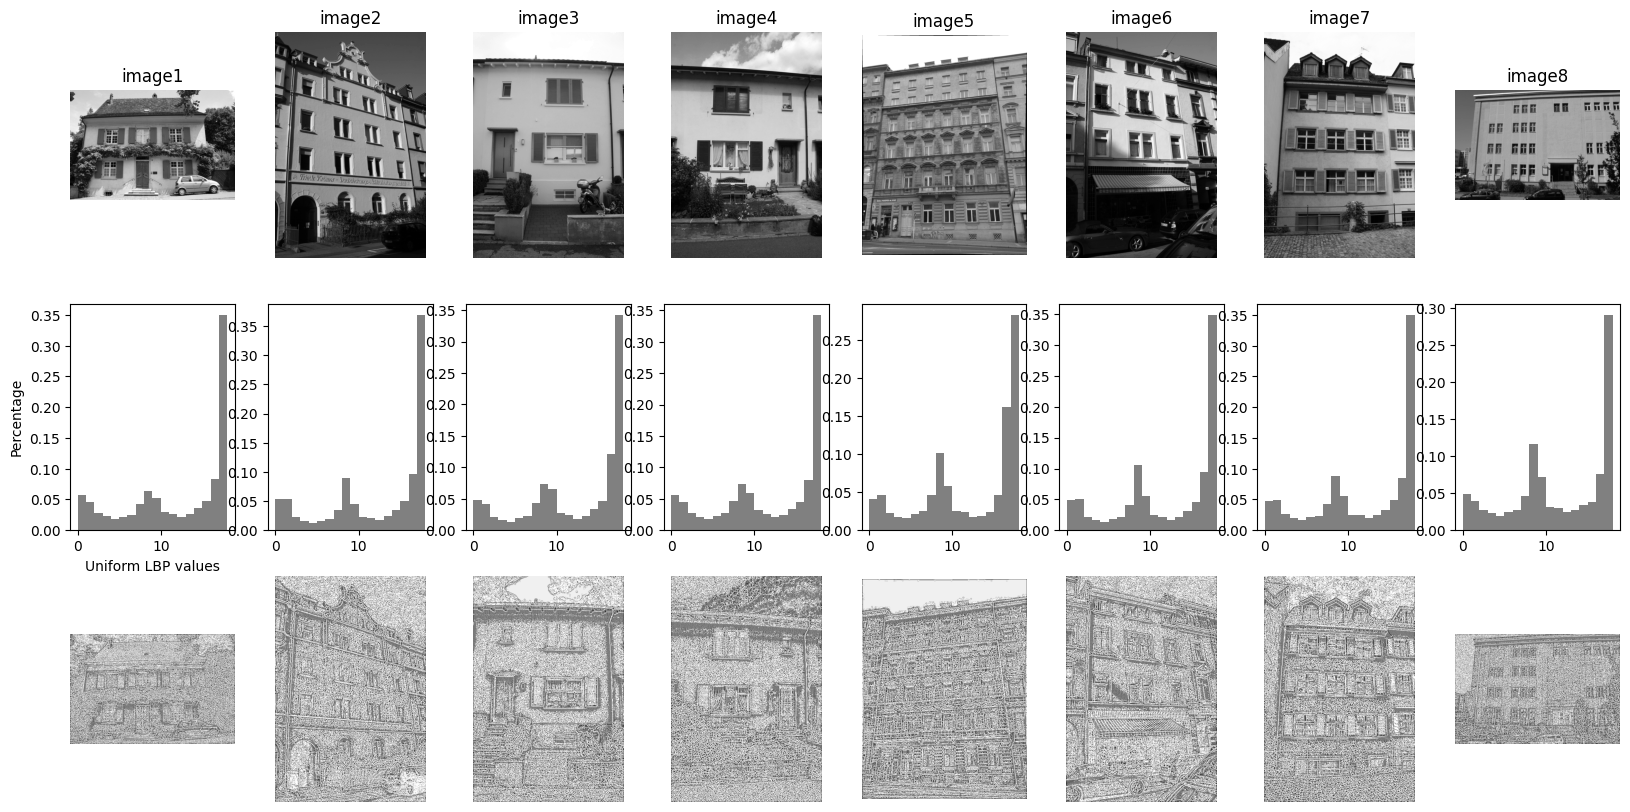

In [453]:
# settings for LBP
radius = 2
n_points = 8 * radius
METHOD = 'uniform'

for i, image_data in enumerate(list(data.values())[:8]):
    # Create dynamic variable names like image1, image2, image3, etc.
    locals()["image{}".format(i+1)] = cv2.cvtColor(image_data.image, cv2.COLOR_BGR2GRAY)

refs = {
    'image1': local_binary_pattern(image1, n_points, radius, METHOD),
    'image2': local_binary_pattern(image2, n_points, radius, METHOD),
    'image3': local_binary_pattern(image3, n_points, radius, METHOD),
    'image4': local_binary_pattern(image4, n_points, radius, METHOD),
    'image5': local_binary_pattern(image5, n_points, radius, METHOD),
    'image6': local_binary_pattern(image6, n_points, radius, METHOD),
    'image7': local_binary_pattern(image7, n_points, radius, METHOD),
    'image8': local_binary_pattern(image8, n_points, radius, METHOD),
}

# Visualize rotated image
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.gray()
ax.imshow(rotate(image1, angle=30, resize=False, mode='symmetric'))
ax.axis('off')
ax.set_title('rotated image1 (angle=30)')
plt.show()

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: image1, rotated: 30deg, match result: ',
      match(refs, rotate(image1, angle=30, resize=False, mode='symmetric')))
print('original: image1, rotated: 70deg, match result: ',
      match(refs, rotate(image1, angle=70, resize=False, mode='symmetric')))
print('original: image2, rotated: 145deg, match result: ',
      match(refs, rotate(image2, angle=145, resize=False, mode='symmetric')))
print()

rotation = 10
print('Rotated image match scores against references using LBP (lower is better):')
print(f'original: image1, rotated: {rotation}deg, match result:')
img1_scores = scores(refs, rotate(image1, angle=rotation, resize=False, mode='symmetric'))
for image_name, image_score in img1_scores.items():
    print(f'{image_name} score: {image_score}')

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20, ax21, ax22, ax23, ax24)) = plt.subplots(nrows=3, ncols=8, figsize=(20,10))
plt.gray()

ax1.imshow(image1)
ax1.axis('off')
ax1.set_title('image1')
ax17.imshow(refs['image1'])
ax17.axis('off')
hist(ax9, refs['image1'])
ax9.set_ylabel('Percentage')
ax9.set_xlabel('Uniform LBP values')

ax2.imshow(image2)
ax2.axis('off')
ax2.set_title('image2')
ax18.imshow(refs['image2'])
ax18.axis('off')
hist(ax10, refs['image2'])

ax3.imshow(image3)
ax3.axis('off')
ax3.set_title('image3')
ax19.imshow(refs['image3'])
ax19.axis('off')
hist(ax11, refs['image3'])

ax4.imshow(image4)
ax4.axis('off')
ax4.set_title('image4')
ax20.imshow(refs['image4'])
ax20.axis('off')
hist(ax12, refs['image4'])

ax5.imshow(image5)
ax5.axis('off')
ax5.set_title('image5')
ax21.imshow(refs['image5'])
ax21.axis('off')
hist(ax13, refs['image5'])

ax6.imshow(image6)
ax6.axis('off')
ax6.set_title('image6')
ax22.imshow(refs['image6'])
ax22.axis('off')
hist(ax14, refs['image6'])

ax7.imshow(image7)
ax7.axis('off')
ax7.set_title('image7')
ax23.imshow(refs['image7'])
ax23.axis('off')
hist(ax15, refs['image7'])

ax8.imshow(image8)
ax8.axis('off')
ax8.set_title('image8')
ax24.imshow(refs['image8'])
ax24.axis('off')
hist(ax16, refs['image8'])

plt.show()

# Testing with only the building face

In [454]:
image_folder = "../data/testing/cropped_building_area"

data = {}
for filename in os.listdir(image_folder):
    name = filename[:-4]  # remove .jpg
    image = cv2.imread(image_folder + "/" + filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    data[name] = gray_image[..., ::-1]

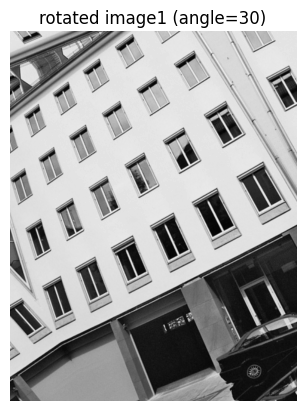

Rotated images matched against references using LBP:
original: image1, rotated: 30deg, match result:  image1
original: image1, rotated: 70deg, match result:  image1
original: image2, rotated: 145deg, match result:  image2

Rotated image match scores against references using LBP (lower is better):
original: image1, rotated: 30deg, match result:
image1 score: 0.04010001196088307
image2 score: 0.09370558153921835
image3 score: 0.04773869319548109
image4 score: 0.10680549117653629
image5 score: 0.07680920865761978
image6 score: 0.10643494845087609
image7 score: 0.07536079912854064
image8 score: 0.07685311415855428


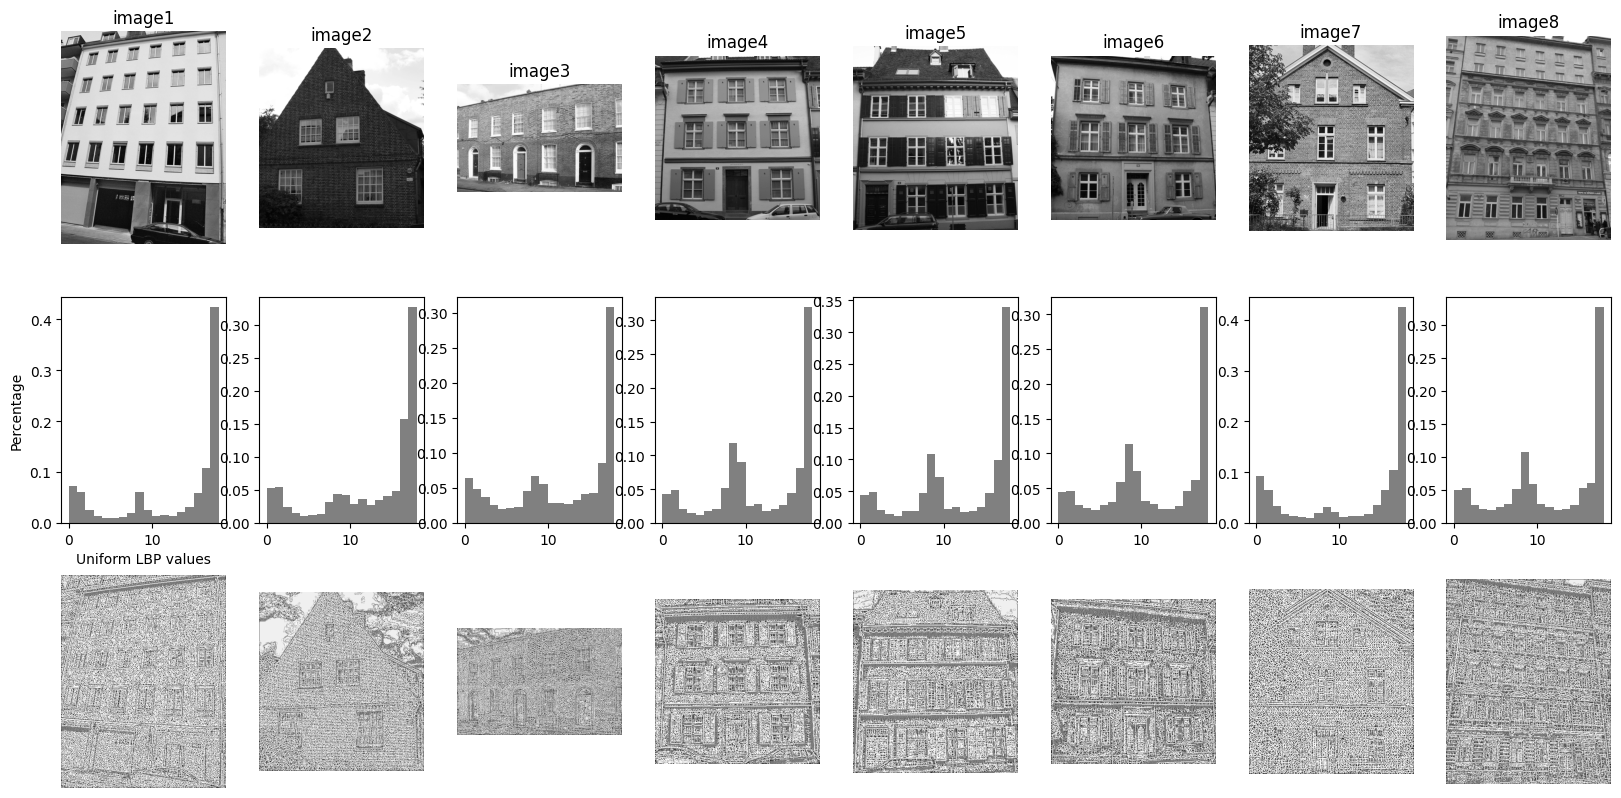

In [455]:
# settings for LBP
radius = 2
n_points = 8 * radius
METHOD = 'uniform'

image1 = list(data.values())[0]
image2 = list(data.values())[1]
image3 = list(data.values())[2]
image4 = list(data.values())[3]
image5 = list(data.values())[4]
image6 = list(data.values())[5]
image7 = list(data.values())[6]
image8 = list(data.values())[7]

refs = {
    'image1': local_binary_pattern(image1, n_points, radius, METHOD),
    'image2': local_binary_pattern(image2, n_points, radius, METHOD),
    'image3': local_binary_pattern(image3, n_points, radius, METHOD),
    'image4': local_binary_pattern(image4, n_points, radius, METHOD),
    'image5': local_binary_pattern(image5, n_points, radius, METHOD),
    'image6': local_binary_pattern(image6, n_points, radius, METHOD),
    'image7': local_binary_pattern(image7, n_points, radius, METHOD),
    'image8': local_binary_pattern(image8, n_points, radius, METHOD),
}

# Visualize rotated image
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.gray()
ax.imshow(rotate(image1, angle=30, resize=False, mode='symmetric'))
ax.axis('off')
ax.set_title('rotated image1 (angle=30)')
plt.show()

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: image1, rotated: 30deg, match result: ',
      match(refs, rotate(image1, angle=30, resize=False, mode='symmetric')))
print('original: image1, rotated: 70deg, match result: ',
      match(refs, rotate(image1, angle=70, resize=False, mode='symmetric')))
print('original: image2, rotated: 145deg, match result: ',
      match(refs, rotate(image2, angle=145, resize=False, mode='symmetric')))
print()

rotation = 30
print('Rotated image match scores against references using LBP (lower is better):')
print(f'original: image1, rotated: {rotation}deg, match result:')
img1_scores = scores(refs, rotate(image1, angle=rotation, resize=False, mode='symmetric'))
for image_name, image_score in img1_scores.items():
    print(f'{image_name} score: {image_score}')

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20, ax21, ax22, ax23, ax24)) = plt.subplots(nrows=3, ncols=8, figsize=(20,10))
plt.gray()

ax1.imshow(image1)
ax1.axis('off')
ax1.set_title('image1')
ax17.imshow(refs['image1'])
ax17.axis('off')
hist(ax9, refs['image1'])
ax9.set_ylabel('Percentage')
ax9.set_xlabel('Uniform LBP values')

ax2.imshow(image2)
ax2.axis('off')
ax2.set_title('image2')
ax18.imshow(refs['image2'])
ax18.axis('off')
hist(ax10, refs['image2'])

ax3.imshow(image3)
ax3.axis('off')
ax3.set_title('image3')
ax19.imshow(refs['image3'])
ax19.axis('off')
hist(ax11, refs['image3'])

ax4.imshow(image4)
ax4.axis('off')
ax4.set_title('image4')
ax20.imshow(refs['image4'])
ax20.axis('off')
hist(ax12, refs['image4'])

ax5.imshow(image5)
ax5.axis('off')
ax5.set_title('image5')
ax21.imshow(refs['image5'])
ax21.axis('off')
hist(ax13, refs['image5'])

ax6.imshow(image6)
ax6.axis('off')
ax6.set_title('image6')
ax22.imshow(refs['image6'])
ax22.axis('off')
hist(ax14, refs['image6'])

ax7.imshow(image7)
ax7.axis('off')
ax7.set_title('image7')
ax23.imshow(refs['image7'])
ax23.axis('off')
hist(ax15, refs['image7'])

ax8.imshow(image8)
ax8.axis('off')
ax8.set_title('image8')
ax24.imshow(refs['image8'])
ax24.axis('off')
hist(ax16, refs['image8'])

plt.show()

In [456]:
images = [image1, image2, image3, image4, image5, image6, image7, image8]

print('Match results of all different images (no rotation).')
for i, image in enumerate(images):
    print()
    print(f'image{i+1} match results (lower is better):')
    img_scores = scores(refs, image)
    for image_name, image_score in img_scores.items():
        print(f'{image_name} score: {image_score}')

Match results of all different images (no rotation).

image1 match results (lower is better):
image1 score: 0.0
image2 score: 0.08206910069631254
image3 score: 0.11041491598558181
image4 score: 0.15304276239092943
image5 score: 0.10334587938907351
image6 score: 0.18019122393169346
image7 score: 0.024202870041127474
image8 score: 0.13700783135081873

image2 match results (lower is better):
image1 score: 0.08999541257395227
image2 score: 0.0
image3 score: 0.06892303166708079
image4 score: 0.13434269799298165
image5 score: 0.09692767611263929
image6 score: 0.17382920051938633
image7 score: 0.12636315894291003
image8 score: 0.15489838606096748

image3 match results (lower is better):
image1 score: 0.12476694828453039
image2 score: 0.06735353332940786
image3 score: 0.0
image4 score: 0.0637072144215516
image5 score: 0.05823616301785163
image6 score: 0.05040796836502484
image7 score: 0.1680160641502927
image8 score: 0.03981523228009036

image4 match results (lower is better):
image1 score: 0.

### Analyzing results

- Images 4 and 5 have similar textural features with each other, and it reflects in the results as well.
- On the other hand, images 2, 3, and 7 all have brick walls but the results fail to reflect that similarity. Instead it may be that other areas such as windows, sky, or vegetation dominate the matching of those images. Tuning of parameters and better cropping of images may be of help here.

# Testing with only the inside of building face (no unrelated areas)

In [457]:
image_folder = "../data/testing/cropped_inside_of_building_area"

data = {}
for filename in os.listdir(image_folder):
    name = filename[:-4]  # remove .jpg
    image = cv2.imread(image_folder + "/" + filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    data[name] = gray_image[..., ::-1]

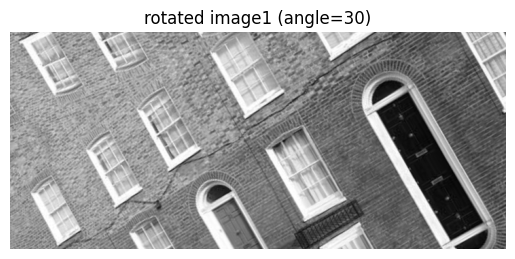

Rotated images matched against references using LBP:
original: image1, rotated: 30deg, match result:  image1
original: image1, rotated: 70deg, match result:  image1
original: image2, rotated: 145deg, match result:  image2

Rotated image match scores against references using LBP (lower is better):
original: image1, rotated: 30deg, match result:
image1 score: 0.014712208813539053
image2 score: 0.05497669948426829
image3 score: 0.14153552122001362
image4 score: 0.0983137354697093
image5 score: 0.11207605188385636
image6 score: 0.07298358739614494
image7 score: 0.12318533240200247
image8 score: 0.08937269627461066


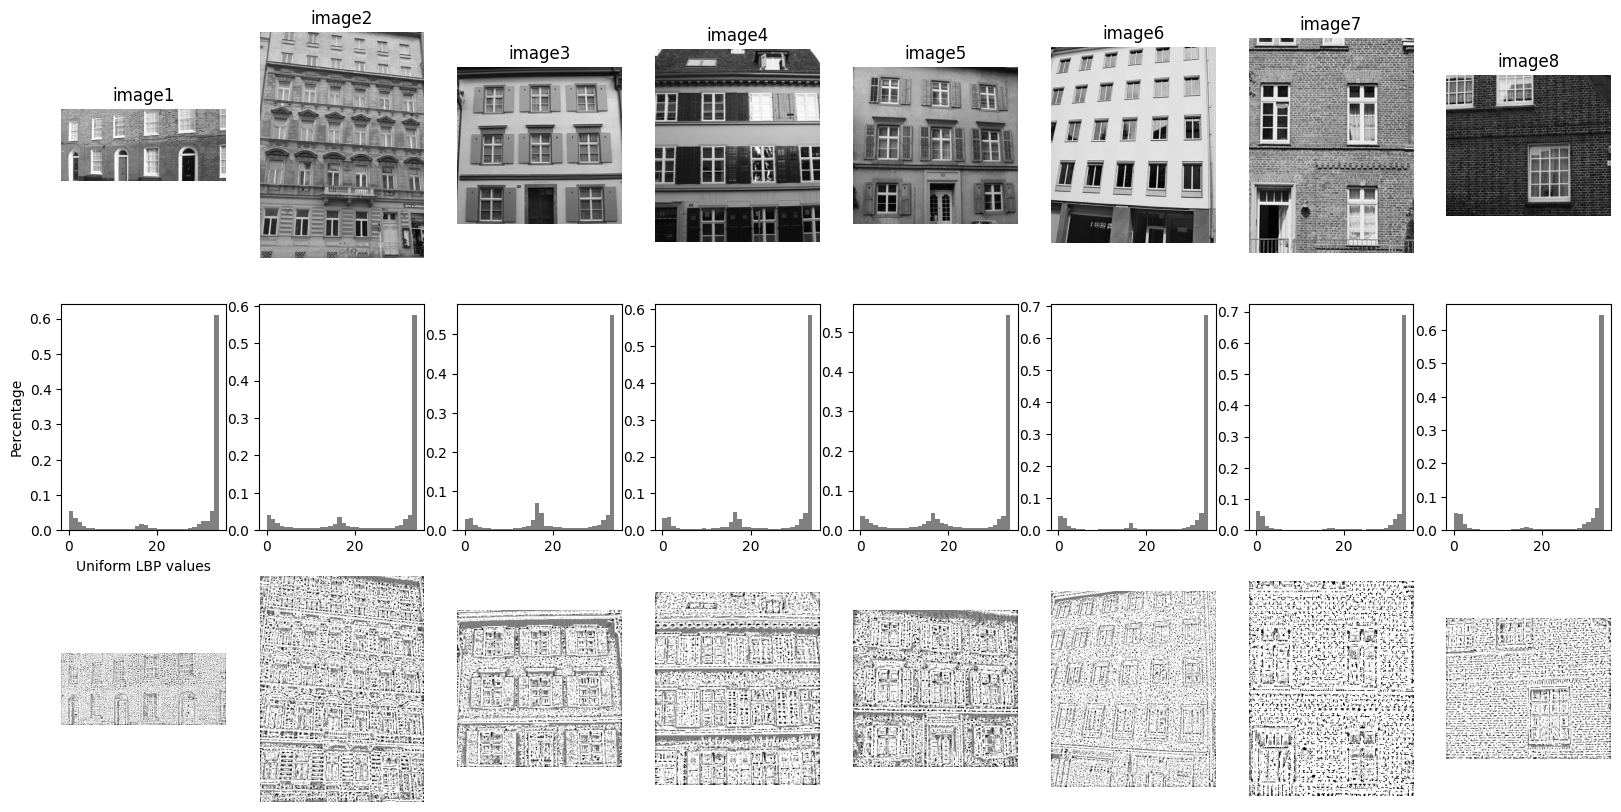

In [462]:
# settings for LBP
radius = 4
n_points = 8 * radius
METHOD = 'uniform'

image1 = list(data.values())[0]
image2 = list(data.values())[1]
image3 = list(data.values())[2]
image4 = list(data.values())[3]
image5 = list(data.values())[4]
image6 = list(data.values())[5]
image7 = list(data.values())[6]
image8 = list(data.values())[7]

refs = {
    'image1': local_binary_pattern(image1, n_points, radius, METHOD),
    'image2': local_binary_pattern(image2, n_points, radius, METHOD),
    'image3': local_binary_pattern(image3, n_points, radius, METHOD),
    'image4': local_binary_pattern(image4, n_points, radius, METHOD),
    'image5': local_binary_pattern(image5, n_points, radius, METHOD),
    'image6': local_binary_pattern(image6, n_points, radius, METHOD),
    'image7': local_binary_pattern(image7, n_points, radius, METHOD),
    'image8': local_binary_pattern(image8, n_points, radius, METHOD),
}

# Visualize rotated image
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.gray()
ax.imshow(rotate(image1, angle=30, resize=False, mode='symmetric'))
ax.axis('off')
ax.set_title('rotated image1 (angle=30)')
plt.show()

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: image1, rotated: 30deg, match result: ',
      match(refs, rotate(image1, angle=30, resize=False, mode='symmetric')))
print('original: image1, rotated: 70deg, match result: ',
      match(refs, rotate(image1, angle=70, resize=False, mode='symmetric')))
print('original: image2, rotated: 145deg, match result: ',
      match(refs, rotate(image2, angle=145, resize=False, mode='symmetric')))
print()

rotation = 30
print('Rotated image match scores against references using LBP (lower is better):')
print(f'original: image1, rotated: {rotation}deg, match result:')
img1_scores = scores(refs, rotate(image1, angle=rotation, resize=False, mode='symmetric'))
for image_name, image_score in img1_scores.items():
    print(f'{image_name} score: {image_score}')

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20, ax21, ax22, ax23, ax24)) = plt.subplots(nrows=3, ncols=8, figsize=(20,10))
plt.gray()

ax1.imshow(image1)
ax1.axis('off')
ax1.set_title('image1')
ax17.imshow(refs['image1'])
ax17.axis('off')
hist(ax9, refs['image1'])
ax9.set_ylabel('Percentage')
ax9.set_xlabel('Uniform LBP values')

ax2.imshow(image2)
ax2.axis('off')
ax2.set_title('image2')
ax18.imshow(refs['image2'])
ax18.axis('off')
hist(ax10, refs['image2'])

ax3.imshow(image3)
ax3.axis('off')
ax3.set_title('image3')
ax19.imshow(refs['image3'])
ax19.axis('off')
hist(ax11, refs['image3'])

ax4.imshow(image4)
ax4.axis('off')
ax4.set_title('image4')
ax20.imshow(refs['image4'])
ax20.axis('off')
hist(ax12, refs['image4'])

ax5.imshow(image5)
ax5.axis('off')
ax5.set_title('image5')
ax21.imshow(refs['image5'])
ax21.axis('off')
hist(ax13, refs['image5'])

ax6.imshow(image6)
ax6.axis('off')
ax6.set_title('image6')
ax22.imshow(refs['image6'])
ax22.axis('off')
hist(ax14, refs['image6'])

ax7.imshow(image7)
ax7.axis('off')
ax7.set_title('image7')
ax23.imshow(refs['image7'])
ax23.axis('off')
hist(ax15, refs['image7'])

ax8.imshow(image8)
ax8.axis('off')
ax8.set_title('image8')
ax24.imshow(refs['image8'])
ax24.axis('off')
hist(ax16, refs['image8'])

plt.show()

In [463]:
images = [image1, image2, image3, image4, image5, image6, image7, image8]

print('Match results of all different images (no rotation).')
for i, image in enumerate(images):
    print()
    print(f'image{i+1} match results (lower is better):')
    img_scores = scores(refs, image)
    for image_name, image_score in img_scores.items():
        print(f'{image_name} score: {image_score}')

Match results of all different images (no rotation).

image1 match results (lower is better):
image1 score: 0.0
image2 score: 0.05026335824062404
image3 score: 0.12575693829015014
image4 score: 0.07503609588878296
image5 score: 0.10717435167633103
image6 score: 0.03678793172964341
image7 score: 0.06740309095453514
image8 score: 0.04228189550464935

image2 match results (lower is better):
image1 score: 0.057133045624370056
image2 score: 0.0
image3 score: 0.04784135617113274
image4 score: 0.027082904572426653
image5 score: 0.016656083922263913
image6 score: 0.10079769171380865
image7 score: 0.19027562196777553
image8 score: 0.17653654690860804

image3 match results (lower is better):
image1 score: 0.15859364292420425
image2 score: 0.05422517819319363
image3 score: 0.0
image4 score: 0.01646007458337824
image5 score: 0.028314648093063003
image6 score: 0.19707356796632078
image7 score: 0.35194494378451835
image8 score: 0.32829536110176266

image4 match results (lower is better):
image1 scor